# ELEC 4542: Project
**Jiang Feiyu 3035770800** </br>
**This is a individual project**
# Task 1
Train an image classification model on CIFAR [3] dataset with ResNet-18 [2]. Report the classifi- cation accuracy on the test set.
For this project, we will use the CIFAR10 dataset. It consists of 60000 32x32 color images in 10 classes, with 6000 images per class. ResNet-18[2] is a convolutional neural network that is 18 layers deep. You can load both the dataset and network easily using torchvision.
## Split CIFAR-10 into training, validation, and testing sets

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import PIL

# Data augmentation transformations for training
train_transform = transforms.Compose([

    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally with a probability of 0.5
    transforms.RandomAffine(degrees=(-5, 5), translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Apply random affine transformations including rotation, translation, and scaling
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Apply color distortion
    transforms.RandomCrop(size=(32, 32), padding=4),  # Randomly crop the image with padding of 4 pixels
    transforms.Resize(size=[32,224], max_size=224,),
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the tensor by scaling pixel values to the range [-1, 1]
])

# Transformation for testing (no data augmentation)
test_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the tensor by scaling pixel values to the range [-1, 1]
])

# Create CIFAR-10 dataset object for training
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
# Split the full training dataset into training set and validation set
train_set, val_set = torch.utils.data.random_split(dataset, [40000, 10000])

# Create data loaders for training and validation sets
train_loader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=False, num_workers=8)

# Create CIFAR-10 dataset object for testing
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
# Create a data loader for the test set
test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=False, num_workers=8)

# Class labels for CIFAR-10
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


ImportError: dlopen(/Users/wodepingguo/opt/anaconda3/envs/torch_nightly_env/lib/python3.8/site-packages/torch/_C.cpython-38-darwin.so, 0x0002): Symbol not found: _cblas_gemm_bf16bf16f32
  Referenced from: <EE5A4EA6-9213-3EE8-AAF0-ED1854D5DB2F> /Users/wodepingguo/opt/anaconda3/envs/torch_nightly_env/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib
  Expected in:     <3E21E8A5-70C9-36CD-8609-8FDF5571F937> /Users/wodepingguo/opt/anaconda3/envs/torch_nightly_env/lib/libmkl_intel_lp64.dylib

## Visualize image for each class

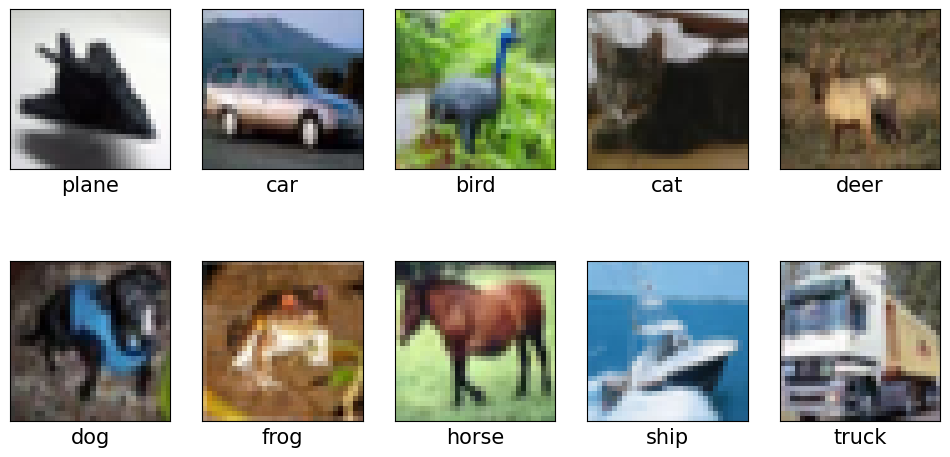

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# visualize training image for each class
sample_images = [dataset.data[np.asarray(dataset.targets) == label][0] for label in range(10)]
# show images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel(classes[i], fontsize=15)
    axis.imshow(sample_images[i])
    i += 1

## Define CNN architecture

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn.parameter import Parameter
import torchvision

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

class LP_ReLU2(nn.Module):

    def __init__(self, in_features, alpha=None):
        super(LP_ReLU2, self).__init__()
        self.in_features = in_features

        if alpha is None:
            self.alpha = Parameter(torch.tensor(6.0))
        else:
            self.alpha = Parameter(torch.tensor(alpha))

        self.alpha.requiresGrad = True

    def forward(self, x):
        threshold0 = torch.zeros(x.shape)
        threshold0 = threshold0.to(device)
        x1 = torch.where(x < threshold0, threshold0, x)

        threshold1 = torch.ones(x1.shape)
        threshold1 = threshold1.to(device)
        threshold1 = threshold1 * (self.alpha)
        x2 = torch.where(x1 < threshold1, x1, threshold1)

        threshold2 = torch.ones(x2.shape)
        threshold2 = threshold2.to(device)
        threshold2 = threshold2 * (self.alpha)
        threshold2 = threshold2.to(device)
        x3 = torch.where(x2 > threshold2, 0.05 * (x2 - threshold2) + threshold2, x2)

        return x3

def get_model():
    # Use the ResNet-18 model
    model = torchvision.models.resnet18(pretrained=False)
    model.fc = nn.Linear(512, 10)  # Update the fully connected layer with 10 output features

    # Change the activation function
    model.relu = LP_ReLU2(64)
    model.layer1[0].relu = LP_ReLU2(64)  # Update the input features of the ReLU layer in each residual block
    model.layer1[1].relu = LP_ReLU2(64)

    return model

# Get the ResNet model with customized components
net = get_model()
net.to(device)
print(net)

Device: cpu


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): LP_ReLU2()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LP_ReLU2()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LP_ReLU2()
      (conv2): Conv2d(64, 

## Training

In [11]:
import torch.optim as optim

# Define the loss function
criterion = nn.CrossEntropyLoss()

optimizer_lst = []
optimizer_lst.append({"params": net.fc.weight, "lr": 0.0001})
optimizer_lst.append({"params": net.fc.bias, "lr": 0.0001})

# Define the optimizer (Stochastic Gradient Descent)
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0)
optimizer = optim.SGD(optimizer_lst, lr=0.001, momentum=0.9, weight_decay=0)

# Learning rate scheduler using ReduceLROnPlateau strategy
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, min_lr=0)

# Lists to store training and validation loss, accuracy
loss_hist, acc_hist = [], []
loss_hist_val, acc_hist_val = [], []

# Training and validation loop
num_epochs = 40  # Set the number of epochs to 40

for epoch in range(num_epochs):
  running_loss = 0.0
  correct = 0

  # Training loop
  for data in train_loader:
    batch, labels = data
    batch, labels = batch.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = net(batch)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # Compute training statistics
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum().item()
    running_loss += loss.item()

  avg_loss = running_loss / len(train_set)
  avg_acc = correct / len(train_set)
  loss_hist.append(avg_loss)
  acc_hist.append(avg_acc)

  # Validation statistics
  net.eval()
  with torch.no_grad():
    loss_val = 0.0
    correct_val = 0

    for data in val_loader:
      batch, labels = data
      batch, labels = batch.to(device), labels.to(device)
      outputs = net(batch)
      loss = criterion(outputs, labels)
      _, predicted = torch.max(outputs, 1)
      correct_val += (predicted == labels).sum().item()
      loss_val += loss.item()

    avg_loss_val = loss_val / len(val_set)
    avg_acc_val = correct_val / len(val_set)
    loss_hist_val.append(avg_loss_val)
    acc_hist_val.append(avg_acc_val)

  net.train()

  # Adjust learning rate based on validation loss
  scheduler.step(avg_loss_val)
  print('[epoch %d] loss: %.5f accuracy: %.4f val loss: %.5f val accuracy: %.4f' % (epoch + 1, avg_loss, avg_acc, avg_loss_val, avg_acc_val))

# Save the trained model
torch.save(net.state_dict(), 'checkpoint60II.pth')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


KeyboardInterrupt: ignored

In [34]:
import torch
torch.save(net.state_dict(), 'checkpoint60II.pth')

## Plotting training statistics

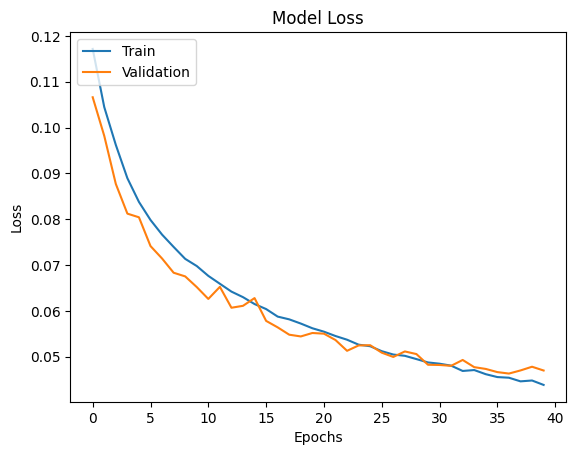

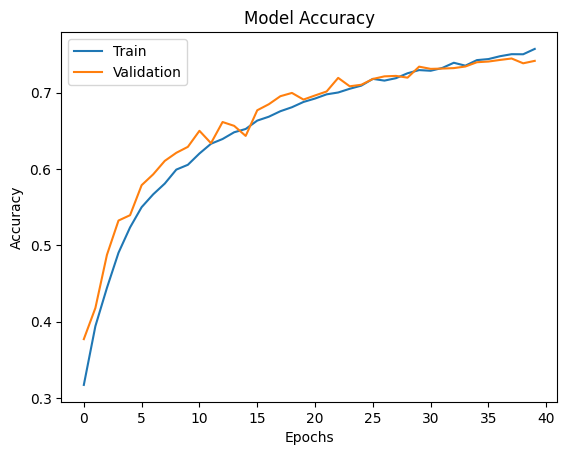

In [35]:
import matplotlib.pyplot as plt

legend = ['Train', 'Validation']
plt.plot(loss_hist)
plt.plot(loss_hist_val)
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(legend, loc='upper left')
plt.show()

legend = ['Train', 'Validation']
plt.plot(acc_hist)
plt.plot(acc_hist_val)
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(legend, loc='upper left')
plt.show()

## Task2
Use different data augmentation techniques and different ways to avoid overfitting. Report the classification accuracy on the test set with different types of data augmentations.

Data Augmentation is simply creating variations of training data to increases its size at the same time regularizes the network. Some common data augmentation techniques in image classification include
- Random Flips and Rotations.
- Random Crop and Center Crop • Normalizing the image
- ...

The choice of data augmentation techniques depends on the specific characteristics of the dataset and the problem at hand. It’s often beneficial to experiment with different combinations of augmentation techniques to find the ones that work best for your task.

In [64]:
from hyperopt import fmin, tpe, hp

# Define the search space for hyperparameters
space = {
    'horizontal_flip_prob': hp.uniform('horizontal_flip_prob', 0, 1),
    'affine_rotation_degrees': hp.uniform('affine_rotation_degrees', 0, 45),
    'affine_translation': hp.uniform('affine_translation', 0, 0.2),
    'affine_scale_range': hp.uniform('affine_scale_range', 0.9, 1.1),
    'color_jitter_brightness': hp.uniform('color_jitter_brightness', 0, 0.5),
    'color_jitter_contrast': hp.uniform('color_jitter_contrast', 0, 0.5),
    'color_jitter_saturation': hp.uniform('color_jitter_saturation', 0, 0.5),
    'color_jitter_hue': hp.uniform('color_jitter_hue', 0, 0.2),  # Fix the range for hue
    'random_crop_padding': hp.uniform('random_crop_padding', 0, 8),
}

# Define the objective function to minimize (validation loss)
def objective(params):
    # Update the data augmentation transformations with the sampled hyperparameters
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=params['horizontal_flip_prob']),
        transforms.RandomAffine(
            degrees=(-params['affine_rotation_degrees'], params['affine_rotation_degrees']),
            translate=(params['affine_translation'], params['affine_translation']),
            scale=(params['affine_scale_range'], params['affine_scale_range'])
        ),
        transforms.ColorJitter(
            brightness=params['color_jitter_brightness'],
            contrast=params['color_jitter_contrast'],
            saturation=params['color_jitter_saturation'],
            hue=params['color_jitter_hue']
        ),
        transforms.RandomCrop(size=(32, 32), padding=int(params['random_crop_padding'])),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Create CIFAR-10 dataset object for training with updated transformations
    dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    train_set, val_set = torch.utils.data.random_split(dataset, [40000, 10000])

    # Create data loader for training set with updated transformations
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True, num_workers=8)

    # Create a ResNet model with customized components
    net = get_model()
    net.to(device)

    # Check if there are trainable parameters in the model
    if any(param.requires_grad for param in net.parameters()):
        # Define the loss function and optimizer only if there are trainable parameters
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0)

        # Training loop
        for epoch in range(5):  # Use a smaller number of epochs for faster evaluation
            running_loss = 0.0
            for data in train_loader:
                batch, labels = data
                batch, labels = batch.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = net(batch)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

        avg_loss_val = validate(net, val_loader, criterion, device)

        return avg_loss_val
    else:
        # Return a large value if there are no trainable parameters (to avoid selecting this configuration)
        return float('inf')

# Helper function to compute validation loss
def validate(model, val_loader, criterion, device):
    model.eval()
    loss_val = 0.0
    correct_val = 0

    with torch.no_grad():
        for data in val_loader:
            batch, labels = data
            batch, labels = batch.to(device), labels.to(device)
            outputs = model(batch)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            loss_val += loss.item()

    avg_loss_val = loss_val / len(val_loader.dataset)
    return avg_loss_val

# Run Bayesian optimization
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10)

# Print the best hyperparameters
print("Best Hyperparameters:", best)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
100%|██████████| 10/10 [00:09<00:00,  1.04trial/s, best loss: inf]
Best Hyperparameters: {'affine_rotation_degrees': 18.40816163336486, 'affine_scale_range': 1.043961617554947, 'affine_translation': 0.18707241992736356, 'color_jitter_brightness': 0.45698307642813485, 'color_jitter_contrast': 0.10082871023770246, 'color_jitter_hue': 0.10615342965569224, 'color_jitter_saturation': 0.00555983105478558, 'horizontal_flip_prob': 0.3100025393336401, 'random_crop_padding': 4.9046579257855445}


## Task3
Visualize the class activation maps of the trained models.
The concept of Class Activation Map (CAM) is introduced in this paper. It is a technique used to visualize the regions of an image that contribute the most to the prediction made by a convolutional neural network for a specific class. CAM provides a way to understand which parts of an image are important for the network’s decision-making process.

5


<ipython-input-10-dac410b1ea9e>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature_map = torch.tensor(feature_map)


6
4
5


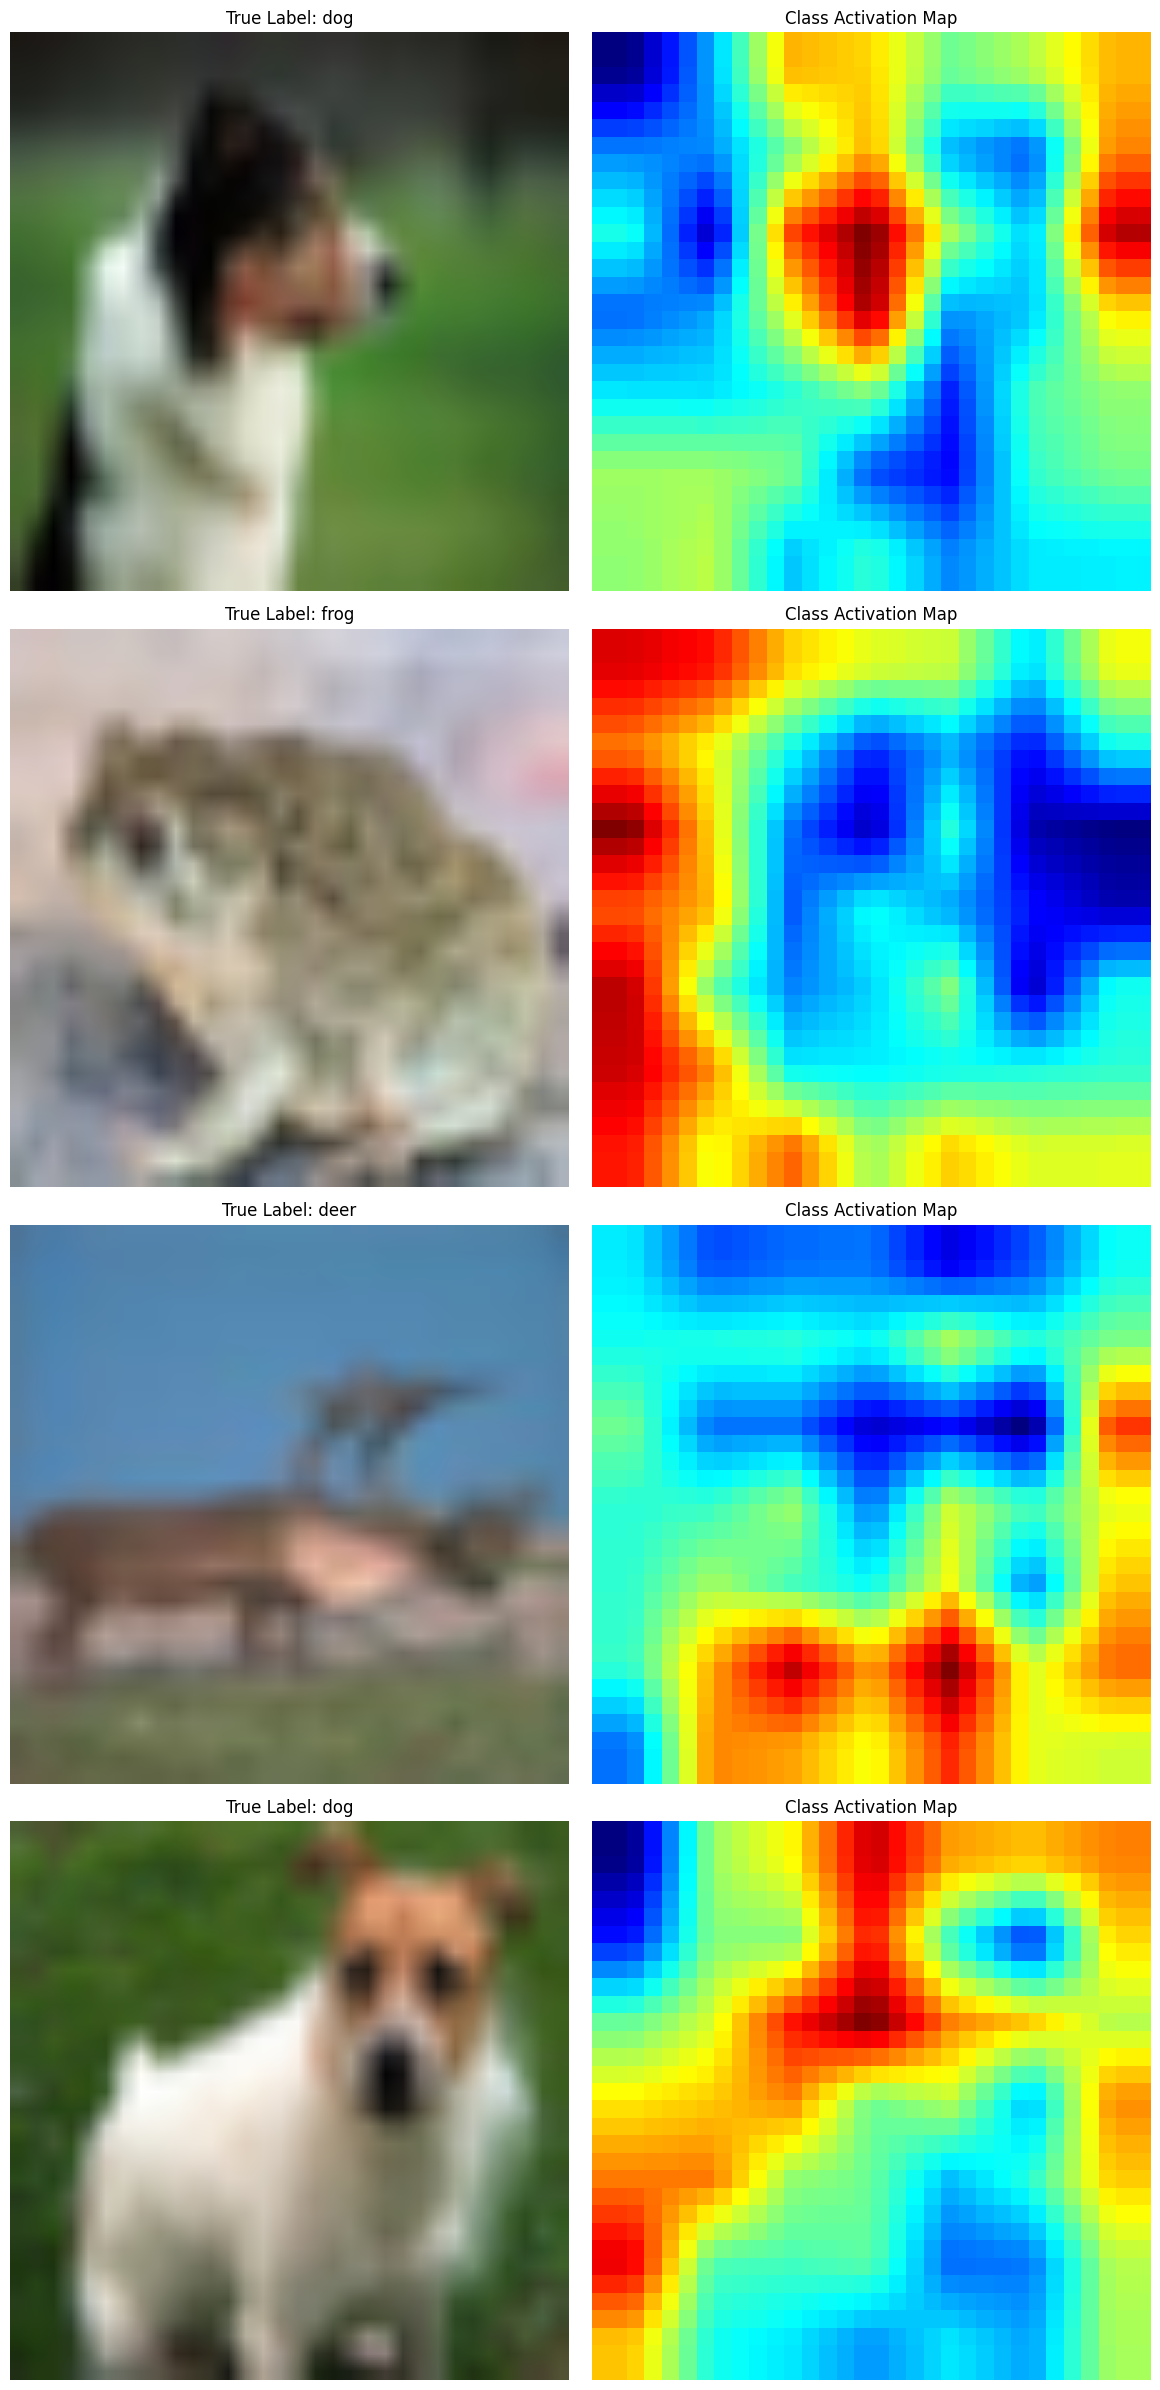

In [10]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
import cv2
import numpy as np

# hook the feature extractor
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.cpu())

# Function to get the CAM for a specific class
def get_cam(model, input_image, target_class):
    # Set the model to evaluation mode
    model.eval()

    # Ensure input_image is a PyTorch tensor
    input_image = input_image.to(device)

    # Get the feature map from the last convolutional layer #改成整个model，不只是conv
    # feature_map = model.layer4[1].conv2(
    #     model.layer4[0].conv1(
    #         model.layer3[1].conv2(
    #           model.layer3[0].conv1(
    #             model.layer2[1].conv2(
    #               model.layer2[0].conv1(
    #                 model.layer1[1].conv2(
    #                     model.layer1[0].conv1(
    #                         model.conv1(input_image))))
    #             ))
    #         ))
    #     )
    net._modules.get("layer4").register_forward_hook(hook_feature)
    logit = model(input_image)
    _, target_class = logit.max(-1)
    target_class = target_class.reshape(-1).cpu()[0]
    print(target_class)

    feature_map = features_blobs[-1]

    params = list(net.parameters())
    weight_softmax = params[-2]

    # Get the weights of the last convolutional layer
    # weights = model.layer4[1].conv2.weight.data
    b, c, h ,w = feature_map.shape
    # for i in features_blobs:
    #   print(i.shape)
    # print(b,c,h,w)

    feature_map = torch.tensor(feature_map)
    feature_map = feature_map.reshape(b,c,h,w).permute(0,2,3,1)
    weight_softmax = weight_softmax.permute(1,0)
    cam = feature_map @ weight_softmax.cpu()
    cam = cam[..., target_class]


    # Normalize the CAM
    # cam = cam - torch.min(cam)
    # cam = cam / torch.max(cam)

    # Resize the CAM to match the input image size
    cam = F.interpolate(cam.unsqueeze(1), size=(32, 32), mode='bilinear', align_corners=False)
    cam = cam.squeeze().cpu().detach().numpy()

    # Normalize the CAM values between 0 and 1
    cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))

    return cam

# Function to overlay the CAM on the input image
def overlay_cam(input_image, cam):
    # Convert the PyTorch tensor to a PIL Image
    input_image_pil = transforms.ToPILImage()(input_image.squeeze(0))

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam_image = heatmap

    # Normalize the CAM image
    cam_image = cam_image / np.max(cam_image)

    # Ensure the CAM image pixel values are in the range [0, 1]
    cam_image = np.clip(cam_image, 0, 1)

    return cam_image

# Choose the number of random images to display
num_images_to_display = 4

# Create subplots for the specified number of images
fig, axes = plt.subplots(num_images_to_display, 2, figsize=(12, 6 * num_images_to_display))

for i in range(num_images_to_display):
    # Choose a random image from the test set
    random_image, true_label = test_set[np.random.randint(len(test_set))]
    random_image = random_image.unsqueeze(0)
    random_image = F.interpolate(random_image, size=(224, 224), mode='bilinear', align_corners=False)

    # Get the CAM for the true label of the random image
    cam = get_cam(net, random_image, true_label)

    # Overlay the CAM on the original image
    cam_image = overlay_cam(random_image, cam)

    # Convert the image back to [0, 1] range for visualization
    input_image_display = (np.transpose(random_image.numpy()[0], (1, 2, 0)) + 1) / 2

    # Display the original image and the CAM overlay in the corresponding subplot
    axes[i, 0].imshow(input_image_display)
    axes[i, 0].set_title(f"True Label: {classes[true_label]}")
    axes[i, 0].axis('off')
    axes[i, 1].imshow(cam_image)
    axes[i, 1].set_title("Class Activation Map")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()
# activation